In [96]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle



from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Sentiment analyse

Bij sentiment analyse gaan we op een geautomatiseerde manier na welk sentiment een bepaald bericht oproept. Deze berichten kunnen bijvoorbeeld afkomstig zijn van posts op sociale media, reviews, opinies en dergelijke. 

Bij deze opdracht is het de bedoeling om tekstberichten op te delen in twee sentiment categorieën, namelijk positief of negatief.
De trainingset is te vinden via het bestand *sentiment_train.csv* en de testset via het bestand *sentiment_test.csv*.

Doorloop daarbij de volgende stappen:

- Vooranalyse van de data: hoe is de dataset verdeeld? Zijn er evenveel positieve als negatieve sentimenten? Is er bijvoorbeeld een verband tussen de lengte van de tekst en het sentiment? 
-  Preprocessing van de tekst: opkuisen van de tekst (stopwoorden, niet-letters verwijderen, omzetten naar lowercase, ...)
- Toepassen van stemming.
- Omzetten naar een bag of words (test hierbij verschillende modellen) en gebruik mogelijks n-grams
- train verschillende classifiers: naive Bayes, logistic regression en SVM. 
- Test de performantie van de verschillende getrainde classifiers via de testset. Kijk daarbij naar de accuracy en f1-score. Interpreteer de resultaten. Kijk ook naar welk algoritme het snelste traint. Bekijk de teksten die verkeerd geclassificeerd werden en zoek naar de oorzaak.

Test het model ook eens met een eigen korte dataset aan sentiment bevattende zinnen.

In [82]:
#inlezen van de dataset
data_sentiment_train = pd.read_csv('sentiment_train.csv')
data_sentiment_test = pd.read_csv('sentiment_test.csv')

#een kolom lengte toevoegen met de lengte van de tekst, om zo te kijken of er een verband is tussen het sentiment & de lengte van de tekst
data_sentiment_train.insert(0, "lengte", data_sentiment_train['text'].apply(len) ,allow_duplicates=True)

data_sentiment_train.head()
# data_sentiment_test.head()
# data_sentiment_train.describe()

,lengte,sentiment,text
0,39,1,The Da Vinci Code book is just awesome.
1,48,0,"Oh, and Brokeback Mountain was a terrible movie."
2,60,1,"He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC..."
3,66,1,1st and 2nd Harry Potter movies are clearly th...
4,38,0,Mission Impossible 3 was quite boring.


In [83]:
#checken of de dataset gebalanceerd is
klasses = data_sentiment_train.sentiment.unique()
print(klasses)
g = data_sentiment_train.groupby('sentiment')
g.count()
#er zijn twee soorten sentimenten & de dataset is min of meer gebalanceerd.

[1 0]


,lengte,text
sentiment,,
0,2535,2535
1,3383,3383


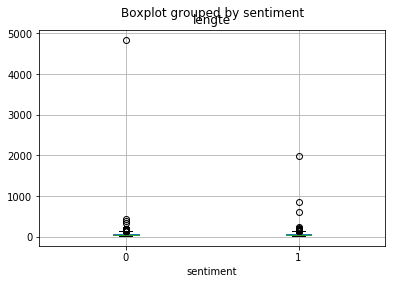

In [84]:
from scipy import stats


data_sentiment_train.boxplot(column='lengte', by="sentiment")

#we zien dat de negatieve reviews een beetje langer zijn dan de positieve, maar dit is geen uitgesproken verschil


In [87]:
#opsplitsen in features & targets
X_train = data_sentiment_train.text.values 
y_train= data_sentiment_train.sentiment.values

X_test = data_sentiment_test.text.values 
y_test = data_sentiment_test.sentiment.values

In [88]:
#preprocessing van de text
def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words


language = 'english'
minWordLength = 2

for i in range(X_train.size):
    X_train[i] = text_preprocessing(X_train[i], language, minWordLength)
    
    
for i in range(X_test.size):
    X_test[i] = text_preprocessing(X_test[i], language, minWordLength)

In [89]:
#we maken onze bag of words aan 
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit(X_train)
X_train_bag_of_words = count_vect.transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

print(X_test_bag_of_words)

tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

  (0, 88)	1
  (0, 584)	1
  (0, 629)	1
  (0, 988)	1
  (0, 1074)	1
  (0, 1125)	1
  (0, 1232)	1
  (0, 1322)	1
  (0, 1332)	1
  (1, 338)	1
  (1, 629)	2
  (1, 857)	1
  (1, 988)	1
  (1, 1074)	2
  (1, 1092)	1
  (1, 1332)	1
  (2, 453)	1
  (2, 715)	1
  (2, 919)	1
  (3, 246)	1
  (3, 313)	1
  (3, 599)	1
  (3, 965)	1
  (3, 1347)	1
  (3, 1494)	1
  :	:
  (997, 363)	1
  (997, 629)	1
  (997, 1074)	1
  (997, 1201)	1
  (998, 246)	1
  (998, 313)	1
  (998, 795)	1
  (998, 857)	1
  (998, 943)	1
  (998, 1029)	1
  (998, 1494)	1
  (998, 1551)	1
  (999, 115)	1
  (999, 122)	1
  (999, 629)	1
  (999, 632)	1
  (999, 889)	1
  (999, 937)	1
  (999, 943)	1
  (999, 1002)	1
  (999, 1052)	1
  (999, 1074)	1
  (999, 1125)	1
  (999, 1340)	1
  (999, 1397)	1


In [90]:
#modellen trainen

#naive bayes

NBclassifier = MultinomialNB(alpha=0.1)

NBclassifier.fit(X_train_tf, y_train)

y_pred = NBclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

             precision    recall  f1-score   support

          0       0.99      0.96      0.97       440
          1       0.97      0.99      0.98       560

avg / total       0.98      0.98      0.98      1000

[[422  18]
 [  6 554]]
97.6


In [99]:
#logistic regression

model = LogisticRegression()

paramaters = [
             {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}                                       
             ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Best accuracy :  0.9959445758702264
Best parameters : {'C': 100}
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       440
          1       0.99      1.00      1.00       560

avg / total       1.00      0.99      0.99      1000

[[436   4]
 [  1 559]]
99.5


In [97]:
#SVM

model = svm.SVC()
paramaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(1,20,100)},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':[1, 10]} ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Best accuracy :  0.9962825278810409
Best parameters : {'C': 3.3030303030303028, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       440
          1       0.99      1.00      0.99       560

avg / total       0.99      0.99      0.99      1000

[[435   5]
 [  1 559]]
99.4


# Movie categorization

Bij deze opdracht zullen classifiers getraind worden om op basis van de beschrijving van een film **één of meerdere genres** aan de film toe te kennen.
Het bestand *Moviedata.csv* bevat van meer dan 40000 films de beschrijving samen met het genre/genres van de film.

Splits de data op in een training- en testset zodat er zeker 5000 samples in de testset zitten (bijvoorbeeld de laatste 5000 films van het Moviedata.csv bestand). De resterende films kunnen gebruikt worden om de classifier mee te trainen.

Doe een vooranalyse van de data: bekijk of de data gebalanceerd is. Komt elk genre met andere woorden evenveel voor? Hoeveel films zijn er met maar 1 genre, hoeveel met 2, etc.

Aangezien een film tot meerdere genres kan behoren is het aangewezen om voor elk genre een aparte classifier te trainen. 

Gebruik zowel logistic resgression, SVM als Naive Bayes. 

Bespreek de resultaten op de testset:
- Wat zijn de accuracy en de f1-score per genre van de verschillende classifiers (logistic regression, SVM en Naive Bayes.
- Wat is de accuracy op basis van volledig correcte classificaties van de films in de trainingset? Hierbij kijk je of een bepaalde film correct aan alle genres is toegekend.
- Welke classifier geniet jouw voorkeur? Bespreek waarom.

Zoek op IMDB.com naar een aantal recente films (die nog niet in de dataset aanwezig zijn) en laat deze classificeren en evalueer de resultaten.





In [4]:
data_movie = pd.read_csv('Moviedata.csv',';')


NameError: name 'pd' is not defined

In [101]:
data_movie.head()

,original_title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science-Fiction,Thriller,TV Movie,War,Western
0,Killing Zoe,Zed (Eric Stoltz) is an American vault-cracker...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,The Arrival,Zane Ziminski is an astrophysicist who receive...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,The Man in the Iron Mask,"Years have passed since the Three Musketeers, ...",1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Gods Must Be Crazy II,"Xixo is back again. This time, his children ac...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Superman IV: The Quest for Peace,With global superpowers engaged in an increasi...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [103]:
#opsplitsen
features_train = list(data_movie.columns[2:data_movie.columns.size])
X_train = data_movie['overview'].values 
y_train= data_movie[features_train].values
print(X_train)
print(y_train)

['Zed (Eric Stoltz) is an American vault-cracker who travels to Paris to meet up with his old friend Eric (Jean-Hugues Anglade). Eric and his gang have planned to raid the only bank in the city which is open on Bastille day. After offering his services, Zed soon finds himself trapped in a situation beyond his control when heroin abuse, poor planning and a call-girl named Zoe all conspire to turn the robbery into a very bloody siege.'
 'Zane Ziminski is an astrophysicist who receives a message that seems to have extraterrestrial origins. Eerily soon after his discovery, Zane is fired. He then embarks on a search to determine the origins of the transmission that leads him into a Hitchcockian labyrinth of paranoia and intrigue.'
 "Years have passed since the Three Musketeers, Aramis, Athos and Porthos, have fought together with their friend, D'Artagnan. But with the tyrannical King Louis using his power to wreak havoc in the kingdom while his twin brother, Philippe, remains imprisoned, th